In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models
import torch.optim as optim
from torch.autograd import Variable
from torchvision import datasets,transforms
from PIL import Image
from tqdm import tqdm
import os
import random
import cv2
import numpy as pd
import pandas as pd
import re

c:\Users\chou0\miniconda3\envs\pytorch8019\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
torch.version.__version__

'1.13.1'

In [3]:
torch.cuda.is_available()

True

In [4]:
# root = "/workspace/Yude/OB file"用3070跑
train_root_dir = 'train'
train_pairs_list = []

for fit_ in ['fit', 'nofit']:
    # fit_dir = f"{root}/{train_root_dir}/{fit_}"用3070跑
    fit_dir = f"{train_root_dir}/{fit_}"#用3070跑
    for pair in os.listdir(fit_dir):
        imgs = os.listdir(f"{fit_dir}/{pair}")
        train_pairs_list.append([
                            f"{fit_dir}/{pair}/{imgs[0]}", 
                            f"{fit_dir}/{pair}/{imgs[1]}",
                            int(fit_ == 'fit')
                            ])
random.shuffle(train_pairs_list)
train_pairs_list

[['train/nofit/nofit1481/AB15590.jpg', 'train/nofit/nofit1481/BA6356.jpg', 0],
 ['train/fit/fit2796/AB16248.jpg', 'train/fit/fit2796/BA6038.jpg', 1],
 ['train/fit/fit2315/AB12935.jpg', 'train/fit/fit2315/BA5503.jpg', 1],
 ['train/nofit/nofit1801/AB13749.jpg', 'train/nofit/nofit1801/QA1173.jpg', 0],
 ['train/fit/fit3060/AB13299.jpg', 'train/fit/fit3060/BA5450.jpg', 1],
 ['train/nofit/nofit2157/AB14170.jpg', 'train/nofit/nofit2157/BA6008.jpg', 0],
 ['train/fit/fit985/AB13034.jpg', 'train/fit/fit985/BA5624.jpg', 1],
 ['train/nofit/nofit202/AB14485.jpg', 'train/nofit/nofit202/KG0909.jpg', 0],
 ['train/nofit/nofit330/BA5859.jpg', 'train/nofit/nofit330/EA3051.jpg', 0],
 ['train/fit/fit727/AB13781.jpg', 'train/fit/fit727/CA2126.jpg', 1],
 ['train/fit/fit2003/AB12280.jpg', 'train/fit/fit2003/BA2098.jpg', 1],
 ['train/nofit/nofit1107/AB14737.jpg', 'train/nofit/nofit1107/KG1075.jpg', 0],
 ['train/nofit/nofit971/BA5888.jpg', 'train/nofit/nofit971/QA1137.jpg', 0],
 ['train/nofit/nofit2003/AB13991.

In [5]:
def train_pairs_loader(train_data, batch_size):
    cnt = len(train_data) // batch_size + int(len(train_data) % batch_size != 0)
    for i in range(cnt):
        temp = i * (batch_size)
        yield train_data[temp : temp + batch_size]

In [6]:
# root = "/workspace/Yude/OB file"用3070跑
val_root_dir = 'test'
val_pairs_list = []

for fit_ in ['fit', 'nofit']:
    # fit_dir = f"{root}/{val_root_dir}/{fit_}"用3070跑
    fit_dir = f"{val_root_dir}/{fit_}"
    for pair in os.listdir(fit_dir):
        imgs = os.listdir(f"{fit_dir}/{pair}")
        val_pairs_list.append([
                            f"{fit_dir}/{pair}/{imgs[0]}", 
                            f"{fit_dir}/{pair}/{imgs[1]}",
                            int(fit_ == 'fit')
                            ])
random.shuffle(val_pairs_list)
val_pairs_list

[['test/fit/fit865/AB16323.jpg', 'test/fit/fit865/BA6038.jpg', 1],
 ['test/fit/fit174/AB14512.jpg', 'test/fit/fit174/BA4345.jpg', 1],
 ['test/nofit/nofit563/BA5901.jpg', 'test/nofit/nofit563/KG1011.jpg', 0],
 ['test/fit/fit163/AB13806.jpg', 'test/fit/fit163/CA2128.jpg', 1],
 ['test/fit/fit284/DA9044.jpg', 'test/fit/fit284/EA3100.jpg', 1],
 ['test/nofit/nofit447/KS0738.jpg', 'test/nofit/nofit447/QA1167.jpg', 0],
 ['test/fit/fit874/DA8676.jpg', 'test/fit/fit874/EA3157.jpg', 1],
 ['test/fit/fit606/AB6125.jpg', 'test/fit/fit606/BA3981.jpg', 1],
 ['test/fit/fit893/AB14013.jpg', 'test/fit/fit893/CA1780.jpg', 1],
 ['test/fit/fit420/AB17053.jpg', 'test/fit/fit420/BA6618.jpg', 1],
 ['test/fit/fit584/AB11478.jpg', 'test/fit/fit584/CA1639.jpg', 1],
 ['test/fit/fit727/AB15057.jpg', 'test/fit/fit727/BA5742.jpg', 1],
 ['test/fit/fit826/AB13793.jpg', 'test/fit/fit826/BA5884.jpg', 1],
 ['test/fit/fit903/AB11819.jpg', 'test/fit/fit903/BA5521.jpg', 1],
 ['test/nofit/nofit308/FA2336.jpg', 'test/nofit/nof

In [7]:
def val_pairs_loader(val_data, batch_size):
    cnt = len(val_data) // batch_size + int(len(val_data) % batch_size != 0)
    for i in range(cnt):
        temp = i * (batch_size)
        yield val_data[temp : temp + batch_size]

In [8]:
#define embeddingnet which is used to extract image emabedding 
class EmbeddingNet(nn.Module):
    def __init__(self):
        super(EmbeddingNet, self).__init__()
        resnet = models.resnet18(pretrained=True)
        resnet.fc = nn.Sequential()
        self.features = resnet
        # ------------------------------------------------------------------------------
        # Remove the last layer (the classification layer) of VGG16 第一種寫法 把原本VGG的最後一層fc layer刪掉 直接線性輸出
        # self.backbone.classifier = nn.Sequential(*list(self.backbone.classifier.children())[:-1])
        # self.features = self.backbone.classifier
        # self.fc = nn.Linear(512, 1)
        # ------------------------------------------------------------------------------
        # 第二種寫法 
        
        self.fc = nn.Sequential(
            nn.Linear(512, 512),
            # nn.LeakyReLU(True),
            # nn.Dropout(),
            # nn.Linear(256, 128),
            # nn.ReLU(True),
            # nn.Dropout(),
            # nn.Linear(128, 10),#原num_classes 這裡要用多少維輸出來代表這個pic
        )
    def forward(self, x):
        #經過VGG提取特徵
        output = self.features(x)
        # print(output.size())
        #flatten 不同模型 這裡的size不同
        #output = output.view(output.size(0)*output.size(1)*output.size(2))
        output = output.view((output.size(0)*output.size(1)))
        # output = output.view((output.size(0), -1))
        # print(output.size())
        # 經過fc層
        output = self.fc(output)
        return output
        
    # def get_embedding(self, x):
        # return self.forward(x)


In [9]:
print(EmbeddingNet())    

EmbeddingNet(
  (features): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, tra

c:\Users\chou0\miniconda3\envs\pytorch8019\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\chou0\miniconda3\envs\pytorch8019\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [10]:
#define siamesenet which have 2 inputs
class SiameseNet(nn.Module):
    def __init__(self, EmbeddingNet):
        super(SiameseNet, self).__init__()
        self.EmbeddingNet = EmbeddingNet
        
    def forward(self, x1, x2):
        output1 = self.EmbeddingNet(x1)
        output2 = self.EmbeddingNet(x2)
        return output1, output2

In [11]:
# embedding_net = EmbeddingNet()
# siamese_net = SiameseNet(embedding_net)
# print(siamese_net)

In [12]:
#define contrastive loss
#loss function reference https://jdhao.github.io/2017/03/13/some_loss_and_explanations/
class ContrastiveLoss(nn.Module):
    def __init__(self, margin=3.5): #margin要自己定義 2
        super(ContrastiveLoss, self).__init__()
        self.margin = margin
        #self.eps = 1e-9
    
    #這邊可以改成不同距離計算方式 這裡先用歐幾里德距離計算
    def forward(self, embedding1, embedding2, label):
        distance = F.pairwise_distance(embedding1, embedding2, p=2)
        #本來最前面是(1-label)
        loss = torch.mean(label * torch.pow(distance, 2) + (1-label) * torch.pow(torch.clamp(self.margin - distance, min=0.0), 2))
        return loss

In [13]:
embedding_net = EmbeddingNet()
siamese_net = SiameseNet(embedding_net)
# print(siamese_net)

#training 
learning_rate = 5e-6
epoch = 15
batch_size = 256
margin = torch.tensor(1.5)

if 4775%batch_size != 0:
    train_bar_len = int((4775/batch_size)+1)
else:
    train_bar_len = int(4775/batch_size)

if 1210%batch_size != 0:
    val_bar_len = int((1210/batch_size)+1)
else:
    val_bar_len = int(1210/batch_size)
    
if torch.cuda.is_available():
    siamese_net.cuda()
    
params = [{'params': md.parameters()} for md in siamese_net.children()
        if md in [siamese_net.EmbeddingNet.fc]]
optimizer = optim.Adam(siamese_net.parameters(), lr=learning_rate)
loss_func = ContrastiveLoss()

train_dataloader = train_pairs_loader(train_pairs_list, batch_size)
siamese_net.train()

transform = transforms.Compose([
    transforms.Resize([224,224]),
    transforms.ToTensor(),
    transforms.Normalize(mean=[.5,.5,.5],std=[.5,.5,.5])
])
#紀錄每個epoch的acc跟loss
train_acc_list = []
train_loss_list = []
val_acc_list = []
val_loss_list = []

for i in range(epoch):
    print(f'epoch {i+1}')
    train_loss = 0.
    train_acc = 0.
    for batch_ in tqdm(train_pairs_loader(train_pairs_list, batch_size), total=train_bar_len):
        for img1_p, img2_p, label_ in batch_ :
            img1 = Image.open(img1_p)
            img2 = Image.open(img2_p)
            img1_t = transform(img1)
            img2_t = transform(img2)
            img1_t_uq = img1_t.unsqueeze(0)
            img2_t_uq = img2_t.unsqueeze(0)
            x1 = Variable(img1_t_uq).cuda()
            x2 = Variable(img2_t_uq).cuda()
            label_ = torch.tensor(label_)#默認int64 float32
            label = Variable(label_).cuda()
            optimizer.zero_grad()
            embedding1, embedding2 = siamese_net(x1, x2)
            loss = loss_func(embedding1, embedding2, label)
            train_loss += loss.item()
            #距離大於或等於margin是不搭 小於margin是搭
            train_distance = F.pairwise_distance(embedding1, embedding2, p=2)
            if train_distance >= margin:
                train_pred = 0
            else:
                train_pred = 1
                
            if train_pred == label_:
                train_acc += 1
            
            loss.backward()
            optimizer.step()

    loss_value = train_loss / (len(train_pairs_list))
    acc_value = train_acc / (len(train_pairs_list))
    train_acc_list.append(100*acc_value)
    train_loss_list.append(loss_value)
    print('Train Loss: {:.6f}, Train Acc: {:.6f}'.format(loss_value, acc_value))
    #-------------------------------------------------------------------------------------------------------------------------------------------------------
    #evalution
    siamese_net.eval()
    val_loss = 0.
    val_acc = 0.
    y_true = []
    y_pred = []
    #還要加tqdm的bar要多長
    for batch_ in tqdm(val_pairs_loader(val_pairs_list, batch_size), total=val_bar_len):
        for img1_p, img2_p, label_ in batch_ :
            img1 = Image.open(img1_p)
            img2 = Image.open(img2_p)
            img1_t = transform(img1)
            img2_t = transform(img2)
            img1_t_uq = img1_t.unsqueeze(0)
            img2_t_uq = img2_t.unsqueeze(0)
            x1 = Variable(img1_t_uq).cuda()
            x2 = Variable(img2_t_uq).cuda()
            label_ = torch.tensor(label_)
            label = Variable(label_).cuda()
            embedding1, embedding2 = siamese_net(x1, x2)
            loss = loss_func(embedding1, embedding2, label)
            val_loss += loss.item()
            #距離大於或等於margin是不搭 小於margin是搭
            val_distance = F.pairwise_distance(embedding1, embedding2, p=2)
            if val_distance >= margin:
                val_pred = 0
            else:
                val_pred = 1
                
            if val_pred == label_:
                val_acc += 1
            #混淆矩陣要用的
            y_true.append(label_)
            y_pred.append(val_pred)
    
    acc_value = val_acc / (len(val_pairs_list))
    loss_value = val_loss / (len(val_pairs_list))
    val_acc_list.append(100*acc_value)
    val_loss_list.append(loss_value)
    print('val Loss: {:.6f}, Val Acc: {:.6f}'.format(loss_value,acc_value))
    


epoch 1


26it [02:05,  4.81s/it]                        


Train Loss: 2.656191, Train Acc: 0.661445


7it [00:18,  2.68s/it]                       


val Loss: 73.007005, Val Acc: 0.376250
epoch 2


26it [06:41, 15.44s/it]                        


Train Loss: 1.903865, Train Acc: 0.795751


7it [00:24,  3.51s/it]                       


val Loss: 1.353223, Val Acc: 0.876250
epoch 3


26it [06:34, 15.18s/it]                        


Train Loss: 0.833242, Train Acc: 0.939051


7it [00:24,  3.49s/it]                       


val Loss: 1.130013, Val Acc: 0.898125
epoch 4


26it [06:30, 15.02s/it]                        


Train Loss: 0.451678, Train Acc: 0.970223


7it [00:24,  3.45s/it]                       


val Loss: 0.857830, Val Acc: 0.926875
epoch 5


26it [06:28, 14.93s/it]                        


Train Loss: 0.296762, Train Acc: 0.978133


7it [00:24,  3.47s/it]                       


val Loss: 0.756448, Val Acc: 0.936250
epoch 6


26it [06:26, 14.85s/it]                        


Train Loss: 0.222555, Train Acc: 0.984646


7it [00:24,  3.43s/it]                       


val Loss: 1.072974, Val Acc: 0.890625
epoch 7


26it [06:24, 14.79s/it]                        


Train Loss: 0.154886, Train Acc: 0.990385


7it [00:23,  3.42s/it]                       


val Loss: 1.254150, Val Acc: 0.870625
epoch 8


26it [06:24, 14.78s/it]                        


Train Loss: 0.119766, Train Acc: 0.993021


7it [00:23,  3.42s/it]                       


val Loss: 0.656452, Val Acc: 0.940000
epoch 9


26it [06:24, 14.79s/it]                        


Train Loss: 0.108122, Train Acc: 0.993952


7it [00:23,  3.43s/it]                       


val Loss: 0.886818, Val Acc: 0.926875
epoch 10


26it [06:24, 14.79s/it]                        


Train Loss: 0.088906, Train Acc: 0.995037


7it [00:24,  3.43s/it]                       


val Loss: 0.668431, Val Acc: 0.948125
epoch 11


26it [06:24, 14.80s/it]                        


Train Loss: 0.113458, Train Acc: 0.993331


7it [00:24,  3.44s/it]                       


val Loss: 0.582658, Val Acc: 0.947500
epoch 12


26it [06:24, 14.79s/it]                        


Train Loss: 0.081469, Train Acc: 0.994882


7it [00:24,  3.47s/it]                       


val Loss: 0.656117, Val Acc: 0.944375
epoch 13


26it [06:24, 14.79s/it]                        


Train Loss: 0.069708, Train Acc: 0.995192


7it [00:24,  3.47s/it]                       


val Loss: 0.643582, Val Acc: 0.954375
epoch 14


26it [06:28, 14.92s/it]                        


Train Loss: 0.068970, Train Acc: 0.995658


7it [00:24,  3.51s/it]                       


val Loss: 1.097880, Val Acc: 0.950000
epoch 15


26it [06:25, 14.83s/it]                        


Train Loss: 0.097315, Train Acc: 0.994262


7it [00:24,  3.50s/it]                       

val Loss: 0.859368, Val Acc: 0.951875


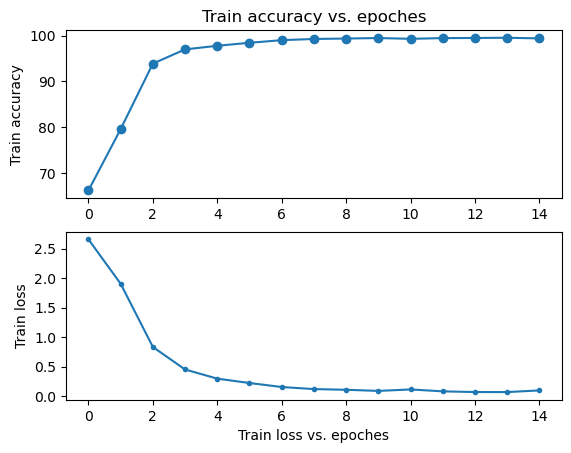

In [14]:
import matplotlib.pyplot as plt

x1 = range(0, epoch)
x2 = range(0, epoch)
y1 = train_acc_list
y2 = train_loss_list
plt.subplot(2, 1, 1)
plt.plot(x1, y1, 'o-')
plt.title('Train accuracy vs. epoches')
plt.ylabel('Train accuracy')
plt.subplot(2, 1, 2)
plt.plot(x2, y2, '.-')
plt.xlabel('Train loss vs. epoches')
plt.ylabel('Train loss')
plt.show()
# plt.savefig("accuracy_loss.jpg")


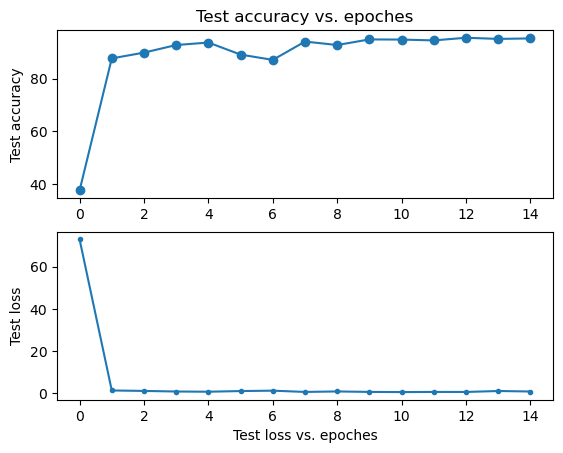

In [15]:
x1 = range(0, epoch)
x2 = range(0, epoch)
y1 = val_acc_list
y2 = val_loss_list
plt.subplot(2, 1, 1)
plt.plot(x1, y1, 'o-')
plt.title('Test accuracy vs. epoches')
plt.ylabel('Test accuracy')
plt.subplot(2, 1, 2)
plt.plot(x2, y2, '.-')
plt.xlabel('Test loss vs. epoches')
plt.ylabel('Test loss')
plt.show()

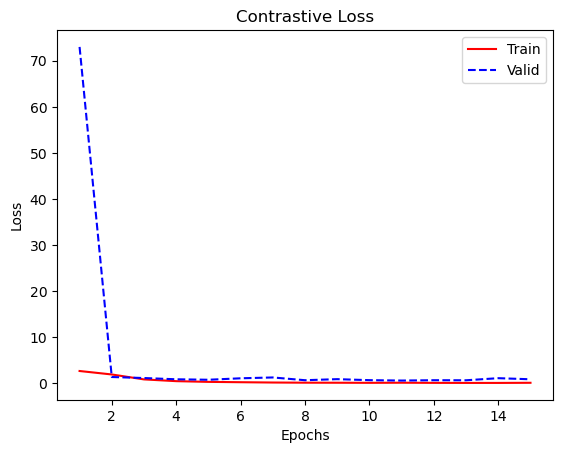

In [16]:
epochs =[i+1 for i in range(epoch)]
plt.plot(epochs,train_loss_list, color='red', label='Train')
plt.plot(epochs,val_loss_list, '--', color='blue', label='Valid')
plt.title('Contrastive Loss') # title
plt.ylabel("Loss") # y label
plt.xlabel("Epochs") # x label
plt.legend() #圖例
plt.show()

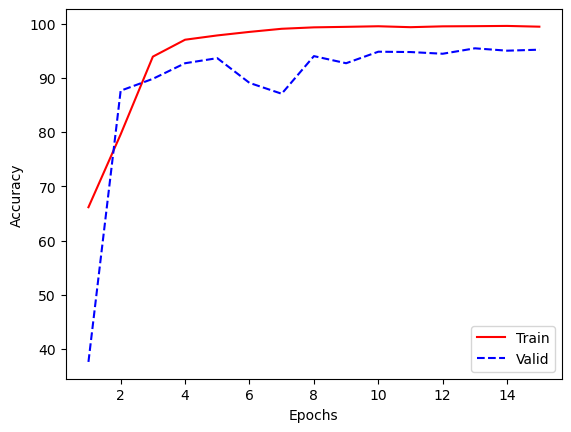

In [17]:
epochs =[i+1 for i in range(epoch)]
plt.plot(epochs,train_acc_list, color='red', label='Train')
plt.plot(epochs,val_acc_list, '--', color='blue', label='Valid')
plt.ylabel("Accuracy") # y label
plt.xlabel("Epochs") # x label
plt.legend() #圖例
plt.show()

In [18]:
a=0
for idx, i in enumerate(y_true):
    if i == 0 and 1 == y_pred[idx]:
        a+=1
a
#fp

47

In [19]:
a=0
for idx, i in enumerate(y_true):
    if i == 0 and 0 == y_pred[idx]:
        a+=1
a
#tn

553

In [20]:
a=0
for idx, i in enumerate(y_true):
    if i == 1 and 1 == y_pred[idx]:
        a+=1
a
#tp

970

In [21]:
a=0
for idx, i in enumerate(y_true):
    if i == 1 and 0 == y_pred[idx]:
        a+=1
a
#fn

30

In [22]:
from sklearn.metrics import confusion_matrix
#官方定義0是positive 1是negative
         #pred
        #   0  1
 #actual#0 tp fn
        #1 fp tn
cm = confusion_matrix(y_true, y_pred)

#我們0是不搭 1是搭
#   0  1
#0 tn fp
#1 fn tp
tn=cm[0][0]
fp=cm[0][1]
fn=cm[1][0]
tp=cm[1][1]
print("Accuracy:",(tp+tn)/(tp+fn+fp+tn) )

p_presicion=tp/(tp+fp)
p_recall=tp/(tp+fn)
print('FIT precision:',p_presicion)
print('FIT recall:',p_recall)

n_presicion=tn/(tn+fn)
n_recall=tn/(fp+tn)
print('n_FIT precision:',n_presicion)
print('n_FIT recall:',n_recall)

print("F1",(2*p_presicion*p_recall)/(p_presicion+p_recall))

Accuracy: 0.951875
FIT precision: 0.9537856440511308
FIT recall: 0.97
n_FIT precision: 0.9485420240137221
n_FIT recall: 0.9216666666666666
F1 0.961824491819534


[0.         0.07833333 1.        ] [0.   0.97 1.  ] [2 1 0]


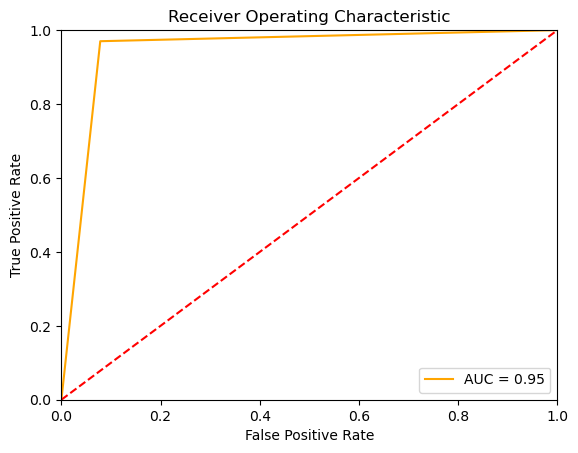

In [23]:
from sklearn.metrics import roc_curve, roc_auc_score, auc
import matplotlib.pyplot as plt
fpr, tpr, threshold = roc_curve(y_true, y_pred)
print(fpr, tpr, threshold)

auc1 = auc(fpr, tpr)
## Plot the result
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, color = 'orange', label = 'AUC = %0.2f' % auc1)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()    

In [24]:
#保存想要的模型參數 
# torch.save(siamese_net.state_dict(), "/workspace/Yude/OB file/resnet93.pt")3070跑的
torch.save(siamese_net.state_dict(), "pt file/512 dim/resnet_m_3p5.pt")

### 利用訓練好的模型取embedding

In [25]:
import numpy as np

class SiameseNet(nn.Module):
    def __init__(self, EmbeddingNet):
        super(SiameseNet, self).__init__()
        self.EmbeddingNet = EmbeddingNet
        
    def forward(self, x1, x2=None):
        output1 = self.EmbeddingNet(x1)
        # output2 = self.EmbeddingNet(x2)
        return output1#, output2
    
#載入之前保存的模型參數
embedding_net = EmbeddingNet()
siamese_net = SiameseNet(embedding_net)

# siamese_net.load_state_dict(torch.load("/workspace/Yude/OB file/resnet80relu.pt"))3070跑的
siamese_net.load_state_dict(torch.load("pt file/512 dim/resnet_m_3p5.pt"))#3070跑的
siamese_net.to("cuda")

# siamese_net.load_state_dict(torch.load("/workspace/Yude/OB file/resnet80relu.pt", map_location= 'cpu'))
# siamese_net.to("cpu")

transform = transforms.Compose([
    transforms.Resize([224,224]),
    transforms.ToTensor(),
    transforms.Normalize(mean=[.5,.5,.5],std=[.5,.5,.5])
])

siamese_net.eval()

#用array的形式保存所有embedding
# img_embedding_array = np.zeros([4775*2,128])
# array_location = 0
# for img1_p, img2_p, label_ in tqdm(train_pairs_list, total=len(train_pairs_list)) :
#             img1 = Image.open(img1_p)
#             img2 = Image.open(img2_p)
#             img1_t = transform(img1)
#             img2_t = transform(img2)
#             img1_t_uq = img1_t.unsqueeze(0)
#             img2_t_uq = img2_t.unsqueeze(0)
#             # x1 = Variable(img1_t_uq).cuda()
#             # x2 = Variable(img2_t_uq).cuda()
#             # x1 = img1_t_uq.cuda()
#             # x2 = img2_t_uq.cuda()
#             x1 = img1_t_uq.cpu()
#             x2 = img2_t_uq.cpu()
#             embedding1, embedding2 = siamese_net(x1, x2)
#             detach_emb1 = embedding1.detach().numpy()
#             detach_emb2 = embedding2.detach().numpy()
#             #存成單純的embedding array
#             img_embedding_array[array_location] = detach_emb1
#             array_location += 1
#             img_embedding_array[array_location] = detach_emb2
#             array_location += 1

#用dataframe刑式保存各類別的embedding 先根據6004筆我們自己整理的去抓 因為跟九瑄之前的上下身標籤有衝突
# top_embedding_df = pd.DataFrame(columns=['item_no','embedding'])
# bottom_embedding_df = pd.DataFrame(columns=['item_no','embedding'])
# outfit_set_latest_swap = pd.read_csv("/workspace/Yude/OB file/csv file/outfit_set_latest_swap.csv",index_col=0)
# top_list = list(set(outfit_set_latest_swap.款號))
# bottom_list = list(set(outfit_set_latest_swap.搭配款))

# top_array_location = 0
# bottom_array_location = 0
# top_embedding_array = np.zeros([6004,128])
# bottom_embedding_array = np.zeros([6004,128])
# for idx, pair in tqdm(outfit_set_latest_swap.iterrows(), total=len(outfit_set_latest_swap)) :
#             img1_p = f'/workspace/Yude/OB file/OB outfit sets/fit/fit{idx}/{pair[0]}.jpg'
#             img2_p = f'/workspace/Yude/OB file/OB outfit sets/fit/fit{idx}/{pair[5]}.jpg'
#             img1 = Image.open(img1_p)
#             img2 = Image.open(img2_p)
#             img1_t = transform(img1)
#             img2_t = transform(img2)
#             img1_t_uq = img1_t.unsqueeze(0)
#             img2_t_uq = img2_t.unsqueeze(0)
#             # x1 = Variable(img1_t_uq).cuda()
#             # x2 = Variable(img2_t_uq).cuda()
#             x1 = img1_t_uq.cuda()
#             x2 = img2_t_uq.cuda()
#             # x1 = img1_t_uq.cpu()
#             # x2 = img2_t_uq.cpu()
#             embedding1, embedding2 = siamese_net(x1, x2)
#             detach_emb1 = embedding1.detach().cpu().numpy()
#             detach_emb2 = embedding2.detach().cpu().numpy()
#             #存成單純的embedding array
#             top_embedding_array[top_array_location] = detach_emb1
#             top_array_location += 1
#             bottom_embedding_array[bottom_array_location] = detach_emb2
#             bottom_array_location += 1
#             top_embedding_df.loc[len(top_embedding_df)] = [pair[0], detach_emb1]
#             bottom_embedding_df.loc[len(bottom_embedding_df)] = [pair[5], detach_emb2]
                        
#處裡完上下身有衝突之後 剩下5063筆
# top_embedding_df = pd.DataFrame(columns=['item_no','embedding'])
# bottom_embedding_df = pd.DataFrame(columns=['item_no','embedding'])
# mixfitdata_df = pd.read_csv("/workspace/Yude/OB file/csv file/mixFitData.csv")[:5063]

# top_array_location = 0
# bottom_array_location = 0
# top_embedding_array = np.zeros([5063,128])
# bottom_embedding_array = np.zeros([5063,128])
# for idx, pair in tqdm(mixfitdata_df.iterrows(), total=len(mixfitdata_df)) :
#             img1_p = f'/workspace/Yude/OB file/@1jpg/{pair[0]}.jpg'
#             img2_p = f'/workspace/Yude/OB file/@1jpg/{pair[3]}.jpg'
#             img1 = Image.open(img1_p)
#             img2 = Image.open(img2_p)
#             img1_t = transform(img1)
#             img2_t = transform(img2)
#             img1_t_uq = img1_t.unsqueeze(0)
#             img2_t_uq = img2_t.unsqueeze(0)
#             # x1 = Variable(img1_t_uq).cuda()
#             # x2 = Variable(img2_t_uq).cuda()
#             x1 = img1_t_uq.cuda()
#             x2 = img2_t_uq.cuda()
#             # x1 = img1_t_uq.cpu()
#             # x2 = img2_t_uq.cpu()
#             embedding1, embedding2 = siamese_net(x1, x2)
#             detach_emb1 = embedding1.detach().cpu().numpy()
#             detach_emb2 = embedding2.detach().cpu().numpy()
#             #存成單純的embedding array
#             top_embedding_array[top_array_location] = detach_emb1
#             top_array_location += 1
#             bottom_embedding_array[bottom_array_location] = detach_emb2
#             bottom_array_location += 1
#             top_embedding_df.loc[len(top_embedding_df)] = [pair[0], detach_emb1]
#             bottom_embedding_df.loc[len(bottom_embedding_df)] = [pair[3], detach_emb2]
            
#5063筆中 上身不重複的有3469筆 下身不重複的有1884筆
top_embedding_df = pd.DataFrame(columns=['item_no','embedding'])
bottom_embedding_df = pd.DataFrame(columns=['item_no','embedding'])
# mixfitdata_df = pd.read_csv("/workspace/Yude/OB file/csv file/mixFitData.csv")[:5063]3070跑的
mixfitdata_df = pd.read_csv("csv file/mixFitData.csv")[:5063]
top_list = list(set(mixfitdata_df.Top))
bottom_list = list(set(mixfitdata_df.Bottom))

top_array_location = 0
bottom_array_location = 0
top_embedding_array = np.zeros([3469,256])
bottom_embedding_array = np.zeros([1884,256])
top_embedding_list = []
bottom_embedding_list = []
#上身
for i in tqdm(top_list, total=len(top_list)):
    # img_p = f'/workspace/Yude/OB file/@1jpg/{i}.jpg'3070跑的
    img_p = f'@1jpg/{i}.jpg'#3070跑的
    img = Image.open(img_p)
    img_t = transform(img)
    img_t_uq = img_t.unsqueeze(0)
    x = img_t_uq.cuda()
    embedding = siamese_net(x)
    detach_emb = embedding.detach().cpu().numpy()
    top_embedding_array[top_array_location] = detach_emb
    top_array_location += 1
    top_embedding_df.loc[len(top_embedding_df)] = [i, detach_emb]
    top_embedding_list.append([i, detach_emb])
#下身
for i in tqdm(bottom_list, total=len(bottom_list)):
    # img_p = f'/workspace/Yude/OB file/@1jpg/{i}.jpg'3070跑的
    img_p = f'@1jpg/{i}.jpg'#3070跑的
    img = Image.open(img_p)
    img_t = transform(img)
    img_t_uq = img_t.unsqueeze(0)
    x = img_t_uq.cuda()
    embedding = siamese_net(x)
    detach_emb = embedding.detach().cpu().numpy()
    bottom_embedding_array[bottom_array_location] = detach_emb
    bottom_array_location += 1
    bottom_embedding_df.loc[len(bottom_embedding_df)] = [i, detach_emb]
    bottom_embedding_list.append([i, detach_emb])
    

c:\Users\chou0\miniconda3\envs\pytorch8019\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\chou0\miniconda3\envs\pytorch8019\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
100%|██████████| 1884/1884 [00:46<00:00, 40.52it/s]


In [26]:
# top_embedding_df.to_pickle("/workspace/Yude/OB file/pickle file/3469_top_embedding.pickle")3070跑的
# bottom_embedding_df.to_pickle("/workspace/Yude/OB file/pickle file/1884_bottom_embedding.pickle")3070跑的
# np.save("/workspace/Yude/OB file/3459_top_embedding_array.npy", top_embedding_array)3070跑的
# np.save("/workspace/Yude/OB file/1884_bottom_embedding_array.npy", bottom_embedding_array)3070跑的

top_embedding_df.to_pickle("pickle file/512 dim/resnet_m_3p5/3469_top_embedding.pickle")#3070跑的
bottom_embedding_df.to_pickle("pickle file/512 dim/resnet_m_3p5/1884_bottom_embedding.pickle")#3070跑的
np.save("npy file/512 dim/resnet_m_3p5/3469_top_embedding_array.npy", top_embedding_array)#3070跑的
np.save("npy file/512 dim/resnet_m_3p5/1884_bottom_embedding_array.npy", bottom_embedding_array)#3070跑的

In [12]:
# #包含圖片路徑跟圖片embedding的list存成pickle檔案
# import pickle

# # Open a file for writing
# with open("/workspace/Yude/OB file/img_embedding_list.pickle", "wb") as f:
#     # Serialize and write the list to the file
#     pickle.dump(img_embedding_list, f)

In [13]:
# # Open the file for reading
# with open("/workspace/Yude/OB file/img_embedding_list.pickle", "rb") as f:
#     # Deserialize the object from the file
#     load_embedding_list = pickle.load(f)

In [29]:
#img_embedding_array存成npy檔案
# np.save("/workspace/Yude/OB file/pure_img_embedding_array.npy", img_embedding_array)
#讀取npy檔案
# x = np.load('x.npy')